In [1]:
# !apt-get --purge remove cuda nvidia* libnvidia-*
# !dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
# !apt-get remove cuda-*
# !apt autoremove
# !apt-get update
# !wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
# !apt-get update
# !apt-get install cuda-9.2
# !pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
# %load_ext nvcc_plugin

In [4]:
# Install libAUC and medMNIST
!pip install libauc==1.2.0
!pip install medmnist
!pip install tensorboardX
!pip install acsconv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator
import os
import argparse
from tqdm import trange
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
# from tensorboardX import SummaryWriter
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

from libauc.losses import AUCMLoss
from libauc.optimizers import PESG
from libauc.metrics import auc_roc_score

from sklearn.metrics import roc_auc_score
from acsconv.converters import Conv3dConverter

import os
import time
from PIL import Image
import numpy as np
import random

random_seed = 41
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [21]:
# Load vesselMNIST3d
data_flag = 'vesselmnist3d'
download = True
as_rgb = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

In [22]:
class Transform3D:

    def __init__(self, mul=None):
        self.mul = mul

    def __call__(self, voxel):
   
        if self.mul == '0.5':
            voxel = voxel * 0.5

        elif self.mul == 'random':
            voxel = voxel * np.random.uniform()
        
        return voxel.astype(np.float32)

In [23]:
random_seed = 41
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

BATCH_SIZE = 64
imratio = 0.1  # for demo
total_epochs = 120
#decay_epochs = [50, 75]
shape_transform = True


# Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

"""
# Define transformations
transform_train = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_val = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
"""

#Transformations
train_transform = Transform3D(mul='random') if shape_transform else Transform3D()
eval_transform = Transform3D(mul='0.5') if shape_transform else Transform3D()

#Define Datasets
train_dataset = DataClass(split='train', transform=train_transform, download=download, as_rgb=as_rgb)
train_dataset_at_eval = DataClass(split='train', transform=eval_transform, download=download, as_rgb=as_rgb)
val_dataset = DataClass(split='val', transform=eval_transform, download=download, as_rgb=as_rgb)
test_dataset = DataClass(split='test', transform=eval_transform, download=download, as_rgb=as_rgb)

# Load data
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset_at_eval, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# Instantiate the ResNet-18 3D model and set it to training mode
from libauc.models import resnet18 as ResNet18
model = ResNet18(pretrained=False)
model = model.cuda()
model.conv1 = nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False)
model = Conv3dConverter(model)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 2)
)

# Define loss function and optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model, loss_fn=loss_fn, momentum=0.8, margin=1.0, epoch_decay=0.05, lr=0.1, weight_decay=1e-7)

# Set early stopping parameters
early_stop_epochs = 10 # Stop if validation AUC does not improve for 10 epochs
best_val_auc = 0
best_test_auc = 0
epochs_since_last_improvement = 0

# Training loop
print('Start Training')
print('-'*40)

train_log = []
test_log = []
val_log = []
for epoch in range(total_epochs):
    train_loss = []
    model = model.cuda()
    model.train()
    for data, targets in train_loader:
        data, targets = data.cuda(), targets.cuda()
        y_pred = model(data)
        loss = loss_fn(y_pred, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # Evaluation on train & test sets
    model.eval()
    train_pred_list = []
    train_true_list = []
    for train_data, train_targets in train_loader_at_eval:
        train_data = train_data.cuda()
        train_pred = model(train_data)
        train_pred_list.append(train_pred.cpu().detach().numpy())
        train_true_list.append(train_targets.numpy())
    train_true = np.concatenate(train_true_list)
    train_pred = np.concatenate(train_pred_list)
    train_auc = auc_roc_score(train_true, train_pred)
    train_loss = np.mean(train_loss)

    val_pred_list = []
    val_true_list = []
    for val_data, val_targets in val_loader:
         val_data = val_data.cuda()
         val_pred = model(val_data)
         val_pred_list.append(val_pred.cpu().detach().numpy())
         val_true_list.append(val_targets.numpy())
    val_true = np.concatenate(val_true_list)
    val_pred = np.concatenate(val_pred_list)
    val_auc =  auc_roc_score(val_true, val_pred)

    test_pred_list = []
    test_true_list = []
    for test_data, test_targets in test_loader:
         test_data = test_data.cuda()
         test_pred = model(test_data)
         test_pred_list.append(test_pred.cpu().detach().numpy())
         test_true_list.append(test_targets.numpy())
    test_true = np.concatenate(test_true_list)
    test_pred = np.concatenate(test_pred_list)
    test_auc =  auc_roc_score(test_true, test_pred) 
    model.train()

    # print results
    print("epoch: %s, train_loss: %.4f, train_auc: %.4f, val_auc: %.4f, test_auc: %.4f, lr: %.4f"%(epoch, train_loss, train_auc[0], val_auc[0], test_auc[0], optimizer.lr ))    
    train_log.append(train_auc[0]) 
    test_log.append(test_auc[0])
    val_log.append(val_auc[0])

    # Check for early stopping
    if val_auc[0] > best_val_auc:
        best_model = model
        best_val_auc = val_auc[0] 
        best_test_auc = test_auc[0] #Test AUC corresponding to best Val AUC
        epochs_since_last_improvement = 0      
    else:
        epochs_since_last_improvement += 1
        if epochs_since_last_improvement >= early_stop_epochs:
            print(f"No improvement in validation AUC for {early_stop_epochs} epochs. Training stopped early.")
            break


Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Start Training
----------------------------------------
epoch: 0, train_loss: 5.6238, train_auc: 0.4720, val_auc: 0.3056, test_auc: 0.4719, lr: 0.1000
epoch: 1, train_loss: 0.0979, train_auc: 0.5362, val_auc: 0.4270, test_auc: 0.5409, lr: 0.1000
epoch: 2, train_loss: 0.0973, train_auc: 0.6072, val_auc: 0.4703, test_auc: 0.5944, lr: 0.1000
epoch: 3, train_loss: 0.0923, train_auc: 0.6612, val_auc: 0.5265, test_auc: 0.6455, lr: 0.1000
epoch: 4, train_loss: 0.0934, train_auc: 0.6730, val_auc: 0.5171, test_auc: 0.6566, lr: 0.1000
epoch: 5, train_loss: 0.0943, train_auc: 0.6999, val_auc: 0.5805, test_auc: 0.6796, lr: 0.1000
epoch: 6, train_loss: 0.0882, train_auc: 0.7093, val_auc: 0.6027, test_auc: 0.6874, lr: 0.1000

In [9]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset VesselMNIST3D (vesselmnist3d)
    Number of datapoints: 1335
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'vessel', '1': 'aneurysm'}
    Number of samples: {'train': 1335, 'val': 192, 'test': 382}
    Description: The VesselMNIST3D is based on an open-access 3D intracranial aneurysm dataset, IntrA, containing 103 3D models (meshes) of entire brain vessels collected by reconstructing MRA images. 1,694 healthy vessel segments and 215 aneurysm segments are generated automatically from the complete models. We fix the non-watertight mesh with PyMeshFix and voxelize the watertight mesh with trimesh into 28×28×28 voxels. We split the source dataset with a ratio of 7:1:2 into training, validation and test set.
    License: CC BY 4.0
Dataset VesselMNIST3D (vesselmnist3d)
    Number of datapoints: 382
    Root location: /root/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    

In [24]:
print(best_test_auc)

0.8990876037593469


In [25]:
state = {
    'net': best_model.state_dict(),
}

output_root = os.path.join('./output', 'AdrenalMNIST3D', time.strftime("%y%m%d_%H%M%S"))
if not os.path.exists(output_root):
    os.makedirs(output_root)

path = os.path.join(output_root, 'best_model.pth')
torch.save(state, path)

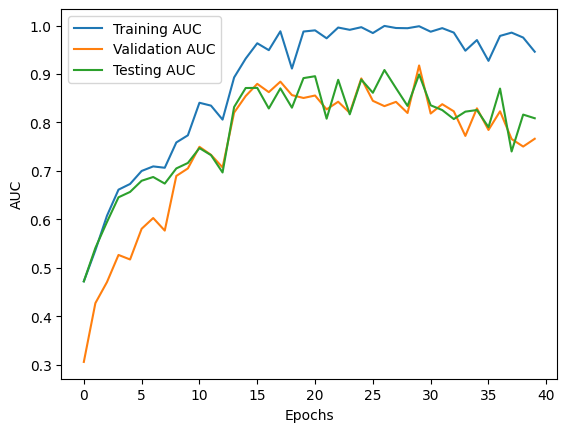

In [26]:
import matplotlib.pyplot as plt

plt.plot(train_log, label='Training AUC')
plt.plot(val_log, label='Validation AUC')
plt.plot(test_log, label='Testing AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()


In [27]:
print("Final Validation AUC:", best_val_auc)
print("Final Test AUC:", best_test_auc)


Final Validation AUC: 0.9176470588235295
Final Test AUC: 0.8990876037593469
